In [1]:
import torch
from tqdm import tqdm
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
from data.FloorPlanLoader import *
from model.VQAE import VQAE
from utils import *
from train import *

#Reproducability Checks:
random.seed(0) #Python
torch.manual_seed(0) #Torch
np.random.seed(0) #NumPy

In [2]:
#Hyperparameter
batch_size = 128
n_hiddens = 32
n_residual_hiddens = 32
n_residual_layers = 1
embedding_dim = 64
n_embeddings = 218
beta = .25
lr = 3e-3
noise=False
noise_weight=0.05
img_channel=1
vqae = VQAE(n_hiddens, n_residual_hiddens, n_residual_layers,
                n_embeddings, embedding_dim, 
                beta, img_channel).to(device)
vqae.load_state_dict(torch.load("best_checkpoint/95-vqae-0.21704871313912527.pt"))

<All keys matched successfully>

In [30]:
#Load Dataset
floor = FloorPlanDataset(multi_scale=False)
data_loader = torch.utils.data.DataLoader(floor, batch_size=218, shuffle=False)

In [33]:
vqae.eval()
latents = None
with torch.no_grad():
    for data in data_loader:
        data = data.to(device)
        embedding_loss, quantized, perplexity, _ = vqae.latent(data)
        if latents is not None:
            latents = torch.cat([latents,quantized],dim=0)
        else: 
            latents = quantized

In [77]:
latents.shape

torch.Size([2806, 64, 14, 14])

In [38]:
torch.flatten(latents, start_dim=1).shape

torch.Size([2806, 12544])

# Embedding Space Visualization

In [55]:
import numpy
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Visualize the latent

D:\Users\ALIENWARE\Anaconda3\envs\torch190\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
D:\Users\ALIENWARE\Anaconda3\envs\torch190\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


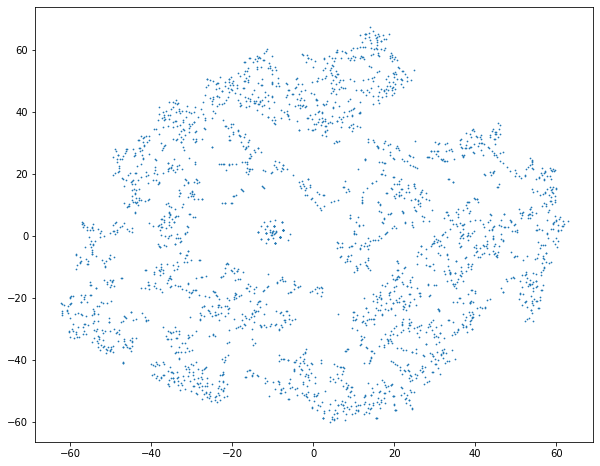

In [62]:
# create tsne object which will reduce data to 2 dimensions
plt.figure(figsize=(10, 8))

tsne = TSNE(n_components=2)
# apply t-SNE to data
data_2d = tsne.fit_transform(torch.flatten(latents, start_dim=1).cpu())
plt.scatter(data_2d[:,0], data_2d[:,1],s=0.5)

# visualise again and highlight actual classes of data

# colours = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'pink', 'orange', 'purple']

# for i in range(10):
#     plt.scatter(data_2d[labels.cpu() == i, 0], data_2d[labels.cpu() == i, 1], c=colours[i])
#     pass

# plt.legend()
plt.show()

### Clustering

In [85]:
#Import required module
from sklearn.cluster import KMeans
 
#Initialize the class object
kmeans = KMeans(n_clusters= 16)
 
#predict the labels of clusters.
label = kmeans.fit_predict(torch.flatten(latents, start_dim=1).cpu())
 
print(label)

[ 4 15 15 ... 15 12  4]


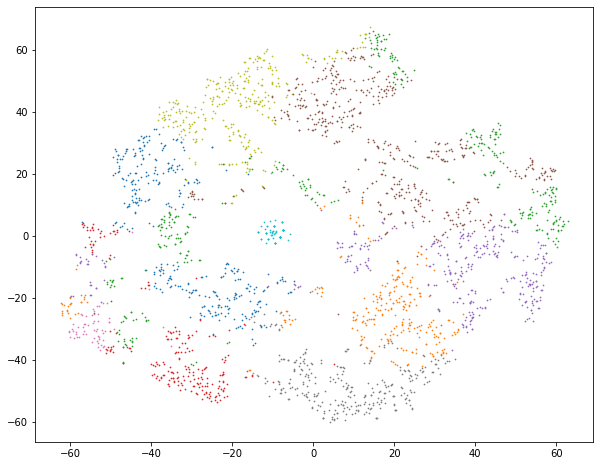

In [86]:
#Getting unique labels
plt.figure(figsize=(10, 8))

u_labels = np.unique(label)
 
#plotting the results:
 
for i in u_labels:
    plt.scatter(data_2d[label == i , 0] , data_2d[label == i , 1] , label = i, s=0.5)
# plt.legend()
plt.show()

### Recon

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


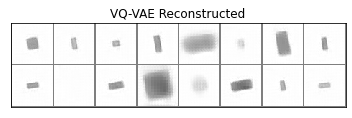

In [88]:
latent_centers = torch.from_numpy(kmeans.cluster_centers_.reshape(16, 64, 14, 14).astype('float32')).to(device)

vqae.eval()

valid_recon = vqae.decoder(latent_centers)
def show(img, title):
    npimg = img.numpy()
    fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    fig.axes.set_title(title)

show(torchvision.utils.make_grid(valid_recon.cpu().data) + 0.5, "VQ-VAE Reconstructed")
plt.show()